<a href="https://colab.research.google.com/github/MatSci495/Lectures/blob/main/MOSFET_SATURATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example 2 — Do we need an extra term in an $I$–$V$ model?

In this example, we explore how to determine whether a small but systematic deviation in a measured MOSFET $I$–$V$ curve justifies adding a new physical term to the model. At low drain bias $V_D$, the current is often well described by a baseline expression that combines a linear term and a weak quadratic contribution associated with the transition toward saturation. However, slight **up-curvature** at larger $V_D$ may indicate **channel-length modulation**, a real physical effect in which the effective channel length decreases with increasing $V_D$, increasing the drain current more than the baseline model predicts.

Our goal is to compare two **nested** models:

- A simpler baseline model $M_0$ that captures the primary dependence of drain current on $V_D$.
- An extended model $M_1$ that introduces a channel-length modulation parameter $\lambda$ through a multiplicative factor $(1 + \lambda V_D)$.

The practical question is whether including $\lambda$ significantly improves the description of the data once we account for measurement noise. Because the variance of current measurements is **unknown**, we will estimate $\hat{\sigma}^2$ from the data and then perform statistical tests that properly acknowledge this uncertainty.

This notebook will guide you through (i) fitting both models, (ii) estimating variance from residuals, (iii) applying an $F$-test for nested models, (iv) computing AIC to penalize unnecessary complexity, and (v) checking residual structure. Your final conclusion should combine numerical evidence, diagnostics, and physical reasoning.


# LEARNING GOALS

## Learning goals

By the end of this example, you should be able to:

1. Fit a **baseline** MOSFET drain-current model $M_0$ to measured (or synthetic) $I$–$V$ data and interpret the fitted parameters.
2. Fit an **extended** model $M_1$ that includes channel-length modulation through a multiplicative factor $(1 + \lambda V_D)$.
3. Estimate the **measurement variance** $\hat{\sigma}^2$ from residuals rather than assuming it is known, and understand the implications for uncertainty in parameter estimates.
4. Apply an **$F$-test for nested models** when variance is estimated from data, and correctly interpret $p$-values in that context.
5. Compute and compare the **Akaike Information Criterion (AIC)** for $M_0$ and $M_1$ to assess whether the extra parameter $\lambda$ is justified when accounting for model complexity.
6. Examine **residual structure** (residuals vs $V_D$, QQ plots, standardized residuals) to detect underfitting, heteroskedasticity, or mis-specified physics.
7. Perform a **parameter-level $t$-test** on $\hat{\lambda}$ to directly evaluate whether the estimated channel-length modulation effect is significantly different from zero, and interpret $\mathrm{SE}(\hat{\lambda})$.
8. Formulate a **clear evidence-based verdict** about whether channel-length modulation is supported, combining both statistical results and physical reasoning.


# BACKGROUND

## Physics context (MOSFET)

In many MOSFET measurements, the drain current $I_D$ increases approximately linearly with drain voltage $V_D$ at low bias. As $V_D$ grows, however, the device approaches saturation and a weak quadratic dependence may appear, producing mild curvature that a simple linear model cannot fully capture. Beyond this, an additional physical effect known as **channel-length modulation** can further increase $I_D$ at higher $V_D$. As the depletion region at the drain expands, the effective channel length shortens, increasing the drain current more than the baseline model predicts.

From a modeling perspective, this effect is often represented by a multiplicative factor $(1 + \lambda V_D)$, where $\lambda$ is typically small. If $\lambda$ is nonzero, the device exhibits a measurable “tilt” in saturation. If $\lambda = 0$, the baseline model may be sufficient. Importantly, measurement scatter alone can create the illusion of weak up-curvature. Without a quantitative framework, it is impossible to tell whether a small trend in the data is physically meaningful or just noise.

In this example we will use synthetic data, where the true behavior is known, to illustrate how to distinguish these cases. We will fit both the baseline and extended models, estimate the variance from the data, compare the models using an $F$-test for nested models, and then penalize complexity using AIC. Finally, we will inspect residual patterns to ensure that the winning model actually captures the shape of the data.


## Physics context (MOSFET)

In many MOSFET measurements, the drain current $I_D$ increases approximately linearly with drain voltage $V_D$ at low bias. As $V_D$ grows, however, the device approaches saturation and a weak quadratic dependence may appear, producing mild curvature that a simple linear model cannot fully capture. Beyond this, an additional physical effect known as **channel-length modulation** can further increase $I_D$ at higher $V_D$. As the depletion region at the drain expands, the effective channel length shortens, increasing the drain current more than the baseline model predicts.

From a modeling perspective, this effect is often represented by a multiplicative factor $(1 + \lambda V_D)$, where $\lambda$ is typically small. If $\lambda$ is nonzero, the device exhibits a measurable “tilt” in saturation. If $\lambda = 0$, the baseline model may be sufficient. Importantly, measurement scatter alone can create the illusion of weak up-curvature. Without a quantitative framework, it is impossible to tell whether a small trend in the data is physically meaningful or just noise.

The the idealized drain current in the linear region is given by:

$$
I_D^{(0)} = \mu C_{\mathrm{ox}} \frac{W}{L} (V_G - V_T) V_D - \tfrac{1}{2}\mu C_{\mathrm{ox}} \frac{W}{L} V_D^2.
$$

The channel length modulation factor can be modeled as:

$$
I_D^{(\mathrm{true})} = I_D^{(0)} \bigl(1 + \lambda V_D\bigr).
$$

<br>

In this example we will use synthetic data, where the true behavior is known, to illustrate how to distinguish these cases. We will fit both the baseline and extended models, estimate the variance from the data, compare the models using an $F$-test for nested models, and then penalize complexity using AIC. Finally, we will inspect residual patterns to ensure that the winning model actually captures the shape of the data.

## Synthetic data setup (hidden truth)

To illustrate this problem, we will generate synthetic data for a MOSFET operated at a fixed gate voltage $V_G$ while sweeping the drain voltage $V_D$. The “true” drain current combines two components:

1. A **baseline** term that captures the roughly linear increase of current with $V_D$ and a weak quadratic contribution associated with the transition toward saturation:
   
   $$
I_D^{(0)}(V_D) = a_1 V_D + a_2 V_D^2.
$$
2. A **channel-length modulation** factor that slightly increases the drain current at higher $V_D$. This is modeled as a multiplicative term with a small parameter $\lambda$:
   
   $$
I_D^{\mathrm{(true)}}(V_D) = I_D^{(0)}(V_D) \, \bigl(1 + \lambda V_D\bigr).
$$

To simulate measurement noise, we add independent Gaussian fluctuations:

$$
I_D^{\mathrm{(obs)}}(V_D) = I_D^{\mathrm{(true)}}(V_D) + \varepsilon,
$$

where $\varepsilon \sim \mathcal{N}(0, \sigma^2)$. The noise variance $\sigma^2$ is modeled with both a constant floor ($\sigma_0^2$) and a component proportional to the square of the true current ($\gamma^2 I_{\mathrm{true}}^2$), reflecting typical measurement characteristics. The variance at each point is given by:

$$
\sigma^2 = \sigma_0^2 + (\gamma \cdot I_{\mathrm{true}})^2
$$

Importantly, the true variance $\sigma^2$ is **unknown** in this example. Rather than supplying weights from a known noise model (as we did in Example 1), we will estimate the variance from residuals. This more closely reflects typical experimental conditions, where uncertainty must be inferred from the data. The distinction becomes critical when deciding whether a small systematic trend represents a real physical effect or random variation.

The key question we will answer later is:
> Does including $\lambda$ significantly improve the model once we properly account for variance estimated from the data?

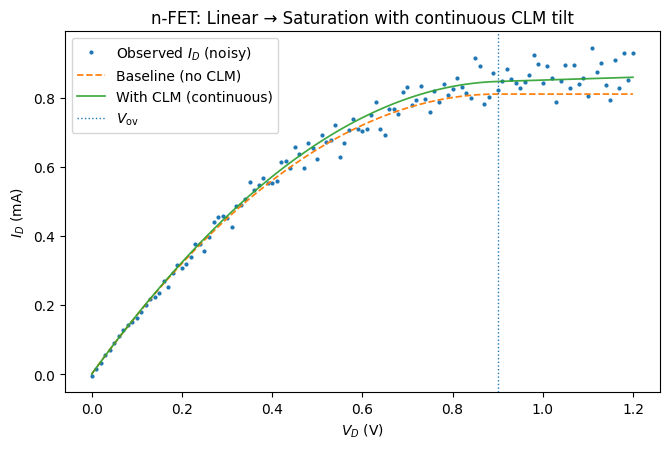

Vg = 1.50 V, Vt = 0.60 V, Vov = 0.90 V
k  = 2.000e-03 A/V^2, lambda_true = 0.050 1/V
I_D (noiseless) range: 0.000 mA to 0.859 mA
Noise: sigma0_true = 5.00 µA, gamma_true = 0.05


In [13]:
# --- Example 2 (MOSFET I–V) — Code Cell 1 (STANDALONE, PATCHED) ---
# Piecewise baseline with saturation + continuous CLM scaling; realistic n-FET scales

import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(10)

# --- Device / experiment settings (n-FET at room temp), fixed gate bias ---
Vg = 1.50          # V (gate voltage)
Vt = 0.60          # V (threshold voltage)
Vov = Vg - Vt      # V (overdrive; saturation onset near Vd ≈ Vov)
k  = 2.0e-3        # A/V^2 (mu*Cox*W/L effective parameter)

# Drain-voltage sweep spanning linear -> saturation
N  = 121
Vd = np.linspace(0.0, 1.20, N)  # V

# --- Baseline piecewise MOSFET model (no CLM) ---
# Linear/Triode (Vd <= Vov):     Id = k * (Vov*Vd - 0.5*Vd^2)
# Saturation   (Vd >  Vov):      Id = 0.5 * k * Vov^2
def Id0_piecewise(V):
    Id_lin = k * (Vov*V - 0.5*V**2)
    Id_sat = 0.5 * k * Vov**2 * np.ones_like(V)
    return np.where(V <= Vov, Id_lin, Id_sat)

# --- Channel-length modulation (CLM) extension with CONTINUOUS scaling ---
# Apply the SAME factor (1 + lambda * Vd) in BOTH regions so there is no jump at Vov.
lambda_true = 0.05  # 1/V  (modest CLM tilt; adjust to change detectability)

def Id1_piecewise_continuous(V):
    Id_base = Id0_piecewise(V)
    return Id_base * (1.0 + lambda_true * V)

# Choose the "true" generating model: include a small CLM effect
Id_true = Id1_piecewise_continuous(Vd)

# --- Heteroskedastic noise model: sigma^2 = sigma0^2 + (gamma * Id_true)^2 ---
sigma0_true = 5e-6      # A   (instrument floor, ~microamp)
gamma_true  = 0.05      # -   (≈5% fractional component)
sigma_true  = np.sqrt(sigma0_true**2 + (gamma_true * np.abs(Id_true))**2)

# Generate noisy observations
noise   = rng.normal(loc=0.0, scale=sigma_true)
Id_obs  = Id_true + noise

# --- Pack everything for later cells ---
data = {
    "Vd": Vd, "Vg": Vg, "Vt": Vt, "Vov": Vov, "k": k,
    "lambda_true": lambda_true,
    "sigma0_true": sigma0_true, "gamma_true": gamma_true,
    "sigma_true": sigma_true, "Id_true": Id_true, "Id_obs": Id_obs
}

# --- Quick sanity plot ---
plt.figure(figsize=(6.8, 4.6))
plt.plot(Vd, Id_obs*1e3, ".", ms=4, label="Observed $I_D$ (noisy)")
plt.plot(Vd, Id0_piecewise(Vd)*1e3, "--", lw=1.25, label="Baseline (no CLM)")
plt.plot(Vd, Id_true*1e3, "-", lw=1.25, alpha=0.9, label="With CLM (continuous)")
plt.axvline(Vov, ls=":", lw=1.0, label="$V_{\\mathrm{ov}}$")
plt.xlabel("$V_D$ (V)")
plt.ylabel("$I_D$ (mA)")
plt.title("n-FET: Linear → Saturation with continuous CLM tilt")
plt.legend()
plt.tight_layout()
plt.show()

# Print quick summary
print(f"Vg = {Vg:.2f} V, Vt = {Vt:.2f} V, Vov = {Vov:.2f} V")
print(f"k  = {k:.3e} A/V^2, lambda_true = {lambda_true:.3f} 1/V")
print(f"I_D (noiseless) range: {Id_true.min()*1e3:.3f} mA to {Id_true.max()*1e3:.3f} mA")
print(f"Noise: sigma0_true = {sigma0_true*1e6:.2f} µA, gamma_true = {gamma_true:.2f}")


# INITIAL MODEL TESTING

## Piecewise Baseline MOSFET Model (No Channel-Length Modulation)

In this example, we approximate the DC drain current of an n-channel MOSFET using a simple
piecewise model that captures the transition from the **linear (triode) region** into the
**saturation (pinch-off) region**, based on the **overdrive voltage**:

$$
V_{\mathrm{ov}} = V_G - V_T
$$

For drain voltages **below** the overdrive voltage, the device behaves approximately like a
voltage-controlled resistor. In this **linear (triode) region**, the incremental channel resistance
drops as $V_D$ increases, resulting in a quadratic dependence of drain current on $V_D$.

For drain voltages **above** the overdrive voltage, the channel is pinched off near the drain, and
the current saturates, becoming approximately independent of $V_D$ (in this simplified baseline).
More accurate models include channel-length modulation, but we begin without it.

We define a *basis function* $f(V_D)$ that produces the correct shape **without** the multiplicative
conductance parameter $k$:

**Linear (triode) region**
$$
V_D \le V_{\mathrm{ov}}:\qquad
f(V_D) = V_{\mathrm{ov}}\,V_D - \tfrac{1}{2} V_D^2
$$

**Saturation region**
$$
V_D > V_{\mathrm{ov}}:\qquad
f(V_D) = \tfrac{1}{2} V_{\mathrm{ov}}^{\,2}
$$

Multiplying this basis function by the scalar parameter $k$ yields the predicted drain current:

$$
I_D^{(0)}(V_D) = k\, f(V_D)
$$

This baseline model captures two key qualitative behaviors:

1. **Quadratic rise** in the linear/triode region as $V_D$ increases.
2. **Current saturation** when $V_D \ge V_{\mathrm{ov}}$ due to channel pinch-off.

This model does *not* yet include channel-length modulation (a small upward tilt in saturation).
We will introduce that later as an additional parameter.


## Stage 1 — Fit the simpler model $M_0$

We begin by fitting the **baseline** drain-current model

$$
I_D^{(0)}(V_D) = a_1 V_D + a_2 V_D^2
$$

to the observed data. This model captures the primary linear increase in drain current with $V_D$ and a weak quadratic contribution associated with the approach to saturation. At this stage, we perform an **ordinary least squares (OLS)** fit, which assumes that all data points have equal variance. Although this assumption will not be correct in general, it provides an initial set of **residuals** that we can later use to estimate the measurement variance.

After fitting, we will:
- Plot the observed data and the fitted curve to verify that the model captures the overall trend.
- Examine **residuals vs $V_D$** to see whether there is systematic upward drift at larger $V_D$, which would indicate underfitting.
- Create a **QQ plot** (quantile–quantile) to check whether the residual distribution is approximately normal.

If the baseline model $M_0$ is too simple, we expect to observe a characteristic **tilt** in the residuals at higher $V_D$. This behavior often suggests the presence of channel-length modulation, which $M_0$ cannot represent. The patterns we observe here will motivate the introduction of an extended model in the next stage.


/tmp/ipython-input-2978706379.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


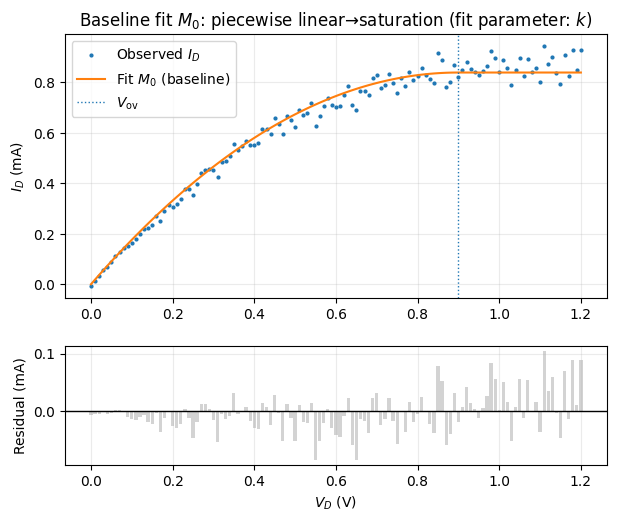

k_hat (M0) = 2.072362e-03 A/V^2
R^2 (M0 OLS) = 0.9826
Mean residual = -2.547e-06 A,  Std(residual) = 3.431e-05 A


In [14]:
# --- Example 2 (MOSFET I–V) — Code Cell 2: Fit baseline M0 by OLS and plot with residuals ---

import numpy as np
import matplotlib.pyplot as plt

# Unpack data prepared in Code Cell 1 (standalone, patched)
Vd       = data["Vd"]
Id_obs   = data["Id_obs"]
Vov      = data["Vov"]

# Basis function for the piecewise baseline model (linear/triode vs saturation), *without* k
#   Linear/Triode (Vd <= Vov):     f(Vd) = (Vov*Vd - 0.5*Vd^2)
#   Saturation   (Vd >  Vov):      f(Vd) = 0.5 * Vov^2
def f_baseline(V):
    f_lin = (Vov*V - 0.5*V**2)
    f_sat = 0.5 * Vov**2 * np.ones_like(V)
    return np.where(V <= Vov, f_lin, f_sat)

X = f_baseline(Vd)          # design vector (size N)
y = Id_obs                  # observed current (A)

# Closed-form OLS for single-parameter k: minimize || y - k*X ||^2
num = np.dot(X, y)
den = np.dot(X, X)
k_hat = num / den

# Predicted current from M0
Id_hat_M0 = k_hat * X

# Residuals (raw; we will standardize later after variance estimation)
resid = y - Id_hat_M0

# Plot: top = data + M0 fit, bottom = residuals vs Vd
fig = plt.figure(figsize=(7.0, 5.6))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.2, 1.0], hspace=0.25) # Increased hspace

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(Vd, y*1e3, ".", ms=4, label="Observed $I_D$")
ax0.plot(Vd, Id_hat_M0*1e3, "-", lw=1.5, label=r"Fit $M_0$ (baseline)")
ax0.axvline(Vov, ls=":", lw=1.0, label=r"$V_{\mathrm{ov}}$")
ax0.set_ylabel("$I_D$ (mA)")
ax0.set_title("Baseline fit $M_0$: piecewise linear→saturation (fit parameter: $k$)")
ax0.legend(loc="best")
ax0.grid(True, alpha=0.25)

ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
ax1.bar(Vd, resid*1e3, width=(Vd[1]-Vd[0])*0.8, color='lightgray') # Changed to bars
ax1.axhline(0.0, color="k", lw=1.0)
ax1.set_xlabel("$V_D$ (V)")
ax1.set_ylabel("Residual (mA)")
ax1.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

# Simple scalar diagnostics for reference
N   = Vd.size
SSR = np.sum((y - Id_hat_M0)**2)     # sum of squared residuals
SST = np.sum((y - np.mean(y))**2)    # total sum of squares
R2  = 1.0 - SSR/SST

print(f"k_hat (M0) = {k_hat:.6e} A/V^2")
print(f"R^2 (M0 OLS) = {R2:.4f}")
print(f"Mean residual = {np.mean(resid):.3e} A,  Std(residual) = {np.std(resid, ddof=1):.3e} A")

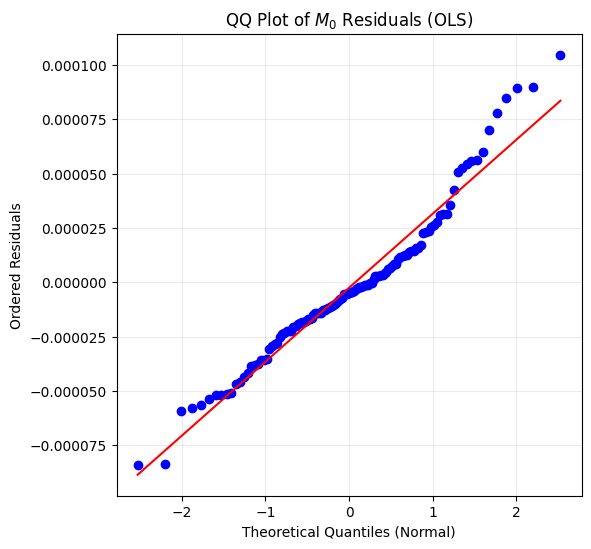

Number of residuals: 121
Mean of residuals: -2.547e-06 A
Standard deviation of residuals: 3.431e-05 A


In [15]:
# --- Example 2 (MOSFET I–V) — Code Cell for M0 Residual QQ Plot ---

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Unpack residuals from the previous cell (Code Cell 2)
resid_M0 = resid  # residuals from OLS fit of M0

# Create a QQ plot
plt.figure(figsize=(6, 6))
stats.probplot(resid_M0, dist="norm", plot=plt)
plt.title("QQ Plot of $M_0$ Residuals (OLS)")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Ordered Residuals")
plt.grid(True, alpha=0.25)
plt.show()

print(f"Number of residuals: {len(resid_M0)}")
print(f"Mean of residuals: {np.mean(resid_M0):.3e} A")
print(f"Standard deviation of residuals: {np.std(resid_M0, ddof=1):.3e} A")

In the $M_0$ QQ plot, observe how closely the points follow the line. Do you see any significant deviations, especially in the tails? This visual assessment helps you understand if the assumption of normally distributed residuals holds for the baseline model. Based on the plot, there appears to be some deviation from the line, particularly in the tails, suggesting the residuals might not be perfectly normally distributed. This could indicate that the $M_0$ model is not fully capturing the underlying data structure.

## Stage 2 — Fit the extended model $M_1$

To account for the systematic up-curvature often seen at larger $V_D$, we extend the baseline with a **channel-length modulation** factor:

$$
I_D^{(1)}(V_D) \;=\; I_D^{(0)}(V_D)\,\bigl(1+\lambda V_D\bigr)
\quad\text{with}\quad
I_D^{(0)}(V_D)=a_1 V_D + a_2 V_D^2.
$$

This introduces a single new parameter $\lambda$ that scales current with $V_D$. The simpler model $M_0$ is recovered by setting $\lambda=0$, so $M_0 \subset M_1$ (nested models).

At this point we still perform an **initial OLS fit** of $M_1$ to obtain residuals and parameter estimates $(\hat a_1,\hat a_2,\hat\lambda)$. The goal here is **diagnostic**:
- Compare plots of data vs fitted curves for $M_0$ and $M_1$.
- Inspect **residuals vs $V_D$** to see whether $M_1$ reduces the high-$V_D$ drift observed under $M_0$.
- Check a **QQ plot** to see whether the residual distribution under $M_1$ is closer to normal.

These comparisons help you judge whether the added term plausibly captures a real effect rather than merely tracking noise. In the next stage, we will **estimate the variance from data** and use it to perform a formal nested-model test and compute AIC.


/tmp/ipython-input-4131466860.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


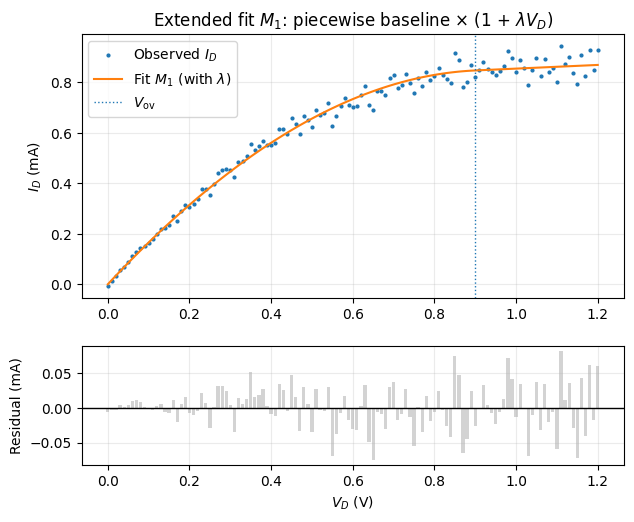

=== OLS results: Extended model M1 ===
k_hat (M1)       = 1.930689e-03 A/V^2
lambda_hat (M1)  = 0.0932 1/V
SSR(M1)          = 1.127788e-07 A^2

--- For reference (baseline M0) ---
k_hat (M0)       = 2.072362e-03 A/V^2
SSR(M0)          = 1.420049e-07 A^2
Delta SSR (M0-M1)= 2.922605e-08 A^2  (positive favors M1)


In [16]:
# --- Example 2 (MOSFET I–V) — Code Cell 3: Fit extended M1 by OLS and plot with residuals ---
# Model: Id ≈ k * f(Vd) * (1 + λ * Vd) = θ1 * f(Vd) + θ2 * f(Vd) * Vd,
# where θ1 = k and θ2 = k*λ  ⇒  λ = θ2 / θ1.

import numpy as np
import matplotlib.pyplot as plt

# Unpack from earlier cells
Vd       = data["Vd"]
Id_obs   = data["Id_obs"]
Vov      = data["Vov"]

def f_baseline(V):
    f_lin = (Vov*V - 0.5*V**2)
    f_sat = 0.5 * Vov**2 * np.ones_like(V)
    return np.where(V <= Vov, f_lin, f_sat)

# Design matrix for linear-in-parameters regression:
# X[:,0] = f(Vd), X[:,1] = f(Vd)*Vd  ->  [θ1, θ2] = argmin || y - X θ ||^2
fV  = f_baseline(Vd)
X   = np.column_stack([fV, fV*Vd])
y   = Id_obs

# Solve OLS (handles possible mild collinearity gracefully)
theta_hat, *_ = np.linalg.lstsq(X, y, rcond=None)
theta1_hat, theta2_hat = theta_hat

# Recover physical parameters
k_hat_M1      = theta1_hat
lambda_hat_M1 = theta2_hat / theta1_hat

# Predictions and residuals
Id_hat_M1 = X @ theta_hat
resid_M1  = y - Id_hat_M1

# For comparison: compute M0 predictions (using the k_hat from Code Cell 2 if available)
# If not available (e.g., after a runtime reset), recompute it here.
def get_k_hat_M0(V, I):
    X0 = f_baseline(V)
    return np.dot(X0, I) / np.dot(X0, X0)

k_hat_M0 = globals().get("k_hat", None)
if k_hat_M0 is None:
    k_hat_M0 = get_k_hat_M0(Vd, Id_obs)
    Id_hat_M0 = k_hat_M0 * fV
    resid_M0  = y - Id_hat_M0
else:
    # If Code Cell 2 already ran, we expect Id_hat_M0 and resid_M0 to exist;
    # if not, recompute to be safe.
    if "Id_hat_M0" not in globals() or "resid" not in globals():
        Id_hat_M0 = k_hat_M0 * fV
        resid_M0  = y - Id_hat_M0
    else:
        resid_M0 = resid  # from previous cell

# Store for later stages (variance estimation & model comparison)
data.update({
    "k_hat_M0": k_hat_M0,
    "k_hat_M1": float(k_hat_M1),
    "lambda_hat_M1": float(lambda_hat_M1),
    "Id_hat_M0": Id_hat_M0,
    "Id_hat_M1": Id_hat_M1,
    "resid_M0": resid_M0,
    "resid_M1": resid_M1
})

# Plot: top = data + M1 fit, bottom = residuals vs Vd (M1)
fig = plt.figure(figsize=(7.0, 5.6))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[2.2, 1.0], hspace=0.25) # Increased hspace

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(Vd, y*1e3, ".", ms=4, label="Observed $I_D$")
ax0.plot(Vd, Id_hat_M1*1e3, "-", lw=1.5, label=r"Fit $M_1$ (with $\lambda$)")
ax0.axvline(Vov, ls=":", lw=1.0, label=r"$V_{\mathrm{ov}}$")
ax0.set_ylabel("$I_D$ (mA)")
ax0.set_title("Extended fit $M_1$: piecewise baseline × (1 + $\\lambda V_D$)")
ax0.legend(loc="best")
ax0.grid(True, alpha=0.25)

ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
ax1.bar(Vd, resid_M1*1e3, width=(Vd[1]-Vd[0])*0.8, color='lightgray') # Changed to bars
ax1.axhline(0.0, color="k", lw=1.0)
ax1.set_xlabel("$V_D$ (V)")
ax1.set_ylabel("Residual (mA)")
ax1.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

# Basic diagnostics and comparison with M0
SSR_M1 = float(np.sum(resid_M1**2))
SSR_M0 = float(np.sum(resid_M0**2))
N      = Vd.size

print("=== OLS results: Extended model M1 ===")
print(f"k_hat (M1)       = {k_hat_M1:.6e} A/V^2")
print(f"lambda_hat (M1)  = {lambda_hat_M1:.4f} 1/V")
print(f"SSR(M1)          = {SSR_M1:.6e} A^2")

print("\n--- For reference (baseline M0) ---")
print(f"k_hat (M0)       = {k_hat_M0:.6e} A/V^2")
print(f"SSR(M0)          = {SSR_M0:.6e} A^2")
print(f"Delta SSR (M0-M1)= {SSR_M0 - SSR_M1:.6e} A^2  (positive favors M1)")

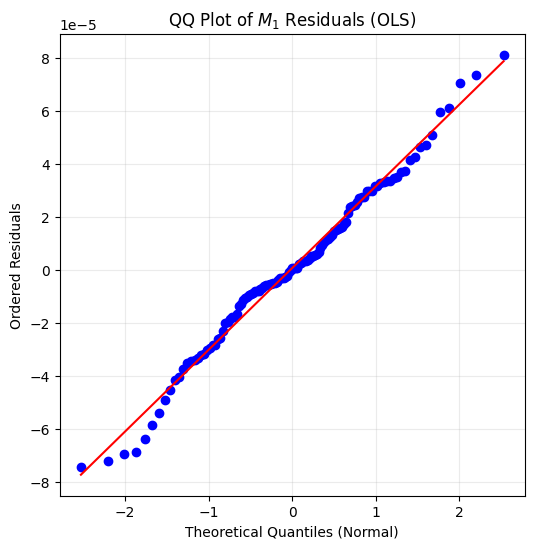

Number of residuals: 121
Mean of residuals: 7.031e-07 A
Standard deviation of residuals: 3.065e-05 A


In [17]:
# --- Example 2 (MOSFET I–V) — Code Cell for M1 Residual QQ Plot ---

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Unpack residuals from the previous cell (Code Cell 3)
resid_M1 = data["resid_M1"]  # residuals from OLS fit of M1

# Create a QQ plot
plt.figure(figsize=(6, 6))
stats.probplot(resid_M1, dist="norm", plot=plt)
plt.title("QQ Plot of $M_1$ Residuals (OLS)")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Ordered Residuals")
plt.grid(True, alpha=0.25)
plt.show()

print(f"Number of residuals: {len(resid_M1)}")
print(f"Mean of residuals: {np.mean(resid_M1):.3e} A")
print(f"Standard deviation of residuals: {np.std(resid_M1, ddof=1):.3e} A")

# VARIANCE ESTIMATION

## Stage 3 — Estimate variance from data and refit with weights (FGLS/WLS)

Up to now, we fitted both $M_0$ and $M_1$ by **ordinary least squares (OLS)**, which implicitly treats every point as equally noisy. Current measurements rarely behave that way; scatter typically grows with signal level. To make fair comparisons and valid tests, we now **estimate the variance model from data** and **refit** using weights.

**3.1. Estimate a simple variance model from residuals.**  
Let $r^{(0)}$ and $r^{(1)}$ be OLS residuals from $M_0$ and $M_1$. We model the pointwise variance as a constant floor plus a term proportional to the squared fitted current:
$$
\widehat{\sigma}_i^2 \;\approx\; \widehat{\sigma}_0^2 \;+\; \widehat{\gamma}^2\,\widehat{I}_i^2,
$$
where $\widehat{I}_i$ can be taken from the **current best fit** (use $M_1$’s fitted values for a single, common variance model). We obtain $(\widehat{\sigma}_0^2,\widehat{\gamma}^2)$ by regressing $r_i^{2}$ on $\widehat{I}_i^{2}$ (nonnegative fit; clip tiny negatives to zero if needed).

**3.2. Form weights and refit both models.**  
Define weights $w_i = 1/\widehat{\sigma}_i^2$. Refit **both** models by weighted least squares (WLS/FGLS):
- $M_0$: minimize $\sum_i w_i\bigl(I_{D,i}^{\mathrm{obs}} - (a_1 V_{D,i} + a_2 V_{D,i}^2)\bigr)^2$  
- $M_1$: minimize $\sum_i w_i\bigl(I_{D,i}^{\mathrm{obs}} - (a_1 V_{D,i} + a_2 V_{D,i}^2)(1+\lambda V_{D,i})\bigr)^2$

This yields **weighted** residuals and **weighted** residual sums of squares:
$$
\chi^2(M_j) \;=\; \sum_i \frac{\bigl(I_{D,i}^{\mathrm{obs}} - \hat I_{D,i}^{(j)}\bigr)^2}{\widehat{\sigma}_i^2},
\qquad j\in\{0,1\}.
$$

**3.3. Why this matters.**  
- Points with larger uncertainty contribute **less** leverage.  
- Parameter standard errors and tests now reflect the **estimated** noise structure.  
- Using a **single, shared** variance model for both $M_0$ and $M_1$ makes the subsequent comparison fair.

**What you should see.**  
Compared to OLS, WLS often **stabilizes** the curvature assessment: residuals at high $V_D$ stop dominating simply because they’re larger in magnitude. If $M_1$ is capturing a real effect, you should observe (i) smaller weighted $\chi^2(M_1)$ than $\chi^2(M_0)$, and (ii) less systematic pattern in residuals vs $V_D$.

*Next:* With weighted fits in hand, we will perform a **nested-model $F$-test** (variance estimated from data) and compute **AIC** to judge whether the added parameter $\lambda$ is justified.


## Comment on approach to noise estimation

That's an excellent point and a very insightful question! You are absolutely correct that the approach used in Stage 3, while estimating the parameters of the variance model ($\hat{\sigma}_0^2$$\hat{\sigma}_0^2$ and $\hat{\gamma}^2$$\hat{\gamma}^2$), still assumes a specific functional form for how the variance depends on the mean ($\sigma^2 \propto \sigma_0^2 + \gamma^2 I^2$$\sigma^2 \propto \sigma_0^2 + \gamma^2 I^2$). It's not a purely empirical, model-free estimation of variance at every single data point.

If you wanted to estimate the variance more empirically without assuming that specific functional form, here are a few approaches:

Replicated Measurements: The most direct empirical way is to take multiple measurements at each unique $V_D$$V_D$ point. If you have $m$$m$ repeated measurements $I_{D,i,1}, I_{D,i,2}, \dots, I_{D,i,m}$$I_{D,i,1}, I_{D,i,2}, \dots, I_{D,i,m}$ at a specific $V_{D,i}$$V_{D,i}$, you can estimate the variance at that point directly from the sample variance of those repeated measurements: $$ \widehat{\sigma}*i^2 = \frac{1}{m-1} \sum*{j=1}^m (I_{D,i,j} - \bar{I}*{D,i})^2 $$$$ \widehat{\sigma}*i^2 = \frac{1}{m-1} \sum*{j=1}^m (I_{D,i,j} - \bar{I}*{D,i})^2 $$ where $\bar{I}*{D,i}$$\bar{I}*{D,i}$ is the mean current at $V_{D,i}$$V_{D,i}$. This requires deliberately designed experiments with repeated measurements.
Binning Residuals: If you don't have exact replicates but have many data points, you can bin the data based on their fitted current values (e.g., group points with similar $\widehat{I}_D$$\widehat{I}_D$). Within each bin, you can calculate the variance of the residuals. This gives you a piecewise constant estimate of the variance as a function of current.
Fit an initial model (like OLS $M_1$$M_1$).
Sort residuals or fitted values by magnitude.
Divide the sorted data into bins (e.g., 10-20 bins).
Calculate the variance of the residuals within each bin.
Assign this bin variance as the estimated variance $\widehat{\sigma}_i^2$$\widehat{\sigma}_i^2$ for all points within that bin.
Refit using WLS with these bin-specific variances.
Moving Window Variance: Similar to binning, you could use a moving window along the sorted fitted values. Calculate the variance of residuals within a window of a fixed number of points, sliding the window along the data.
Non-parametric Regression of Squared Residuals: Instead of assuming a linear relationship between $r^2$$r^2$ and $\hat{I}^2$$\hat{I}^2$ (as in Stage 3's regression), you could use a non-parametric regression technique (like LOESS or splines) to model the relationship between the squared OLS residuals ($r_i^2$$r_i^2$) and the fitted values ($\widehat{I}*i$$\widehat{I}*i$) or $V*{D,i}$$V*{D,i}$. The fitted curve from this non-parametric regression provides the estimate $\widehat{\sigma}_i^2$$\widehat{\sigma}_i^2$.
Comparison to the Notebook's Approach:

The notebook's approach ($\sigma^2 \propto \sigma_0^2 + \gamma^2 I^2$$\sigma^2 \propto \sigma_0^2 + \gamma^2 I^2$) is a semi-empirical method. It's empirical because it uses the data (residuals) to estimate the parameters ($\sigma_0, \gamma$$\sigma_0, \gamma$). However, it's not fully empirical because it imposes a specific physical model (constant floor + signal-proportional) on how that variance behaves.

This semi-empirical approach is common and practical when you have some physical insight into the likely sources of noise (like instrument noise and shot/thermal noise proportional to current) but don't have explicit repeated measurements. It strikes a balance between a rigid, known-variance model and a completely model-free (and often data-hungry) empirical estimation.

Purely empirical methods (like replication or binning) are more robust if you have no idea how the noise behaves, but they often require more data or specific experimental design (replicates).

So, while the notebook's method estimates variance from the data, it does so within the framework of a assumed variance model. Fully empirical methods estimate variance without assuming such a model beforehand.

## Comment

**Comment on approach to noise estimation**

That's an excellent point and a very insightful question! You are absolutely correct that the approach used in Stage 3, while estimating the parameters of the variance model ($\hat{\sigma}_0^2$ and $\hat{\gamma}^2$), still assumes a specific functional form for how the variance depends on the mean ($\sigma^2 \propto \sigma_0^2 + \gamma^2 I^2$). It's not a purely empirical, model-free estimation of variance at every single data point.

If you wanted to estimate the variance more empirically without assuming that specific functional form, here are a few approaches:

Replicated Measurements: The most direct empirical way is to take multiple measurements at each unique $V_D$ point. If you have $m$ repeated measurements $I_{D,i,1}, I_{D,i,2}, \dots, I_{D,i,m}$ at a specific $V_{D,i}$, you can estimate the variance at that point directly from the sample variance of those repeated measurements: $$ \widehat{\sigma}_i^2 = \frac{1}{m-1} \sum_{j=1}^m (I_{D,i,j} - \bar{I}_{D,i})^2 $$ where $\bar{I}_{D,i}$ is the mean current at $V_{D,i}$. This requires deliberately designed experiments with repeated measurements.
Binning Residuals: If you don't have exact replicates but have many data points, you can bin the data based on their fitted current values (e.g., group points with similar $\widehat{I}_D$). Within each bin, you can calculate the variance of the residuals. This gives you a piecewise constant estimate of the variance as a function of current.
Fit an initial model (like OLS $M_1$).
Sort residuals or fitted values by magnitude.
Divide the sorted data into bins (e.g., 10-20 bins).
Calculate the variance of the residuals within each bin.
Assign this bin variance as the estimated variance $\widehat{\sigma}_i^2$ for all points within that bin.
Refit using WLS with these bin-specific variances.
Moving Window Variance: Similar to binning, you could use a moving window along the sorted fitted values. Calculate the variance of residuals within a window of a fixed number of points, sliding the window along the data.
Non-parametric Regression of Squared Residuals: Instead of assuming a linear relationship between $r^2$ and $\hat{I}^2$ (as in Stage 3's regression), you could use a non-parametric regression technique (like LOESS or splines) to model the relationship between the squared OLS residuals ($r_i^2$) and the fitted values ($\widehat{I}_i$) or $V_{D,i}$. The fitted curve from this non-parametric regression provides the estimate $\widehat{\sigma}_i^2$.
Comparison to the Notebook's Approach:

The notebook's approach ($\sigma^2 \propto \sigma_0^2 + \gamma^2 I^2$) is a semi-empirical method. It's empirical because it uses the data (residuals) to estimate the parameters ($\sigma_0, \gamma$). However, it's not fully empirical because it imposes a specific physical model (constant floor + signal-proportional) on how that variance behaves.

This semi-empirical approach is common and practical when you have some physical insight into the likely sources of noise (like instrument noise and shot/thermal noise proportional to current) but don't have explicit repeated measurements. It strikes a balance between a rigid, known-variance model and a completely model-free (and often data-hungry) empirical estimation.

Purely empirical methods (like replication or binning) are more robust if you have no idea how the noise behaves, but they often require more data or specific experimental design (replicates).

So, while the notebook's method estimates variance from the data, it does so within the framework of a assumed variance model. Fully empirical methods estimate variance without assuming such a model beforehand.

## Code

/tmp/ipython-input-1102254329.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


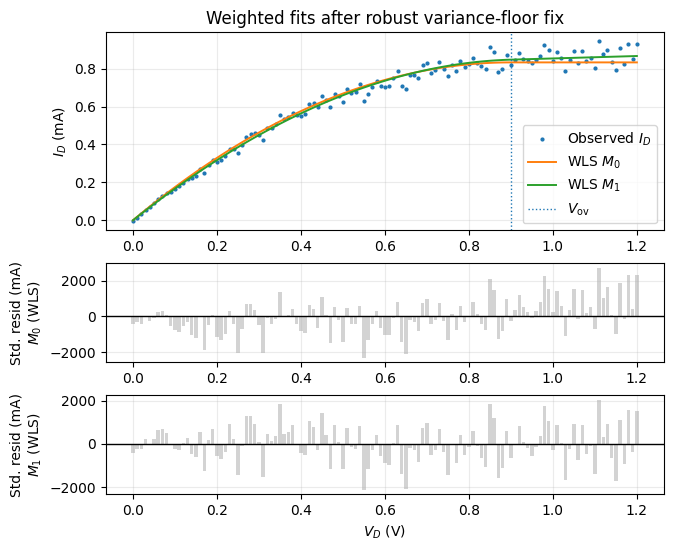

=== Robust variance model (shared) ===
sigma0_hat (floor) ≈ 1.268e-05 A,  gamma_hat ≈ 0.045

=== Weighted lack-of-fit  ===
chi2(M0) = 115.658
chi2(M1) = 90.723
Δchi2 (M0-M1) = 24.935  (positive favors M1)


In [18]:
# --- Example 2 (MOSFET I–V) — Code Cell 4R: Robust variance floor + WLS refits (shared weights) ---
# This cell replaces Code Cell 4 to prevent unrealistically tiny variance at low current (e.g., Vd ~ 0).

import numpy as np
import matplotlib.pyplot as plt

# Unpack from earlier cells
Vd        = data["Vd"]
Id_obs    = data["Id_obs"]
Vov       = data["Vov"]
Id_hat_M1 = data["Id_hat_M1"]       # OLS fit prediction for M1 (from Code Cell 3)
resid_M1  = data["resid_M1"]        # OLS residuals for M1 (from Code Cell 3)

# Baseline basis (no CLM in basis)
def f_baseline(V):
    f_lin = (Vov*V - 0.5*V**2)
    f_sat = 0.5 * Vov**2 * np.ones_like(V)
    return np.where(V <= Vov, f_lin, f_sat)

fV = f_baseline(Vd)
X0 = fV[:, None]
X1 = np.column_stack([fV, fV*Vd])
y  = Id_obs

# --- R.1 Estimate variance model from OLS M1 residuals: r^2 ≈ alpha + beta * (yhat)^2
r2   = resid_M1**2
Z    = np.column_stack([np.ones_like(Id_hat_M1), Id_hat_M1**2])

# small ridge to stabilize the intercept if needed
ridge = 1e-18 * np.eye(2)
beta_hat = np.linalg.solve(Z.T @ Z + ridge, Z.T @ r2)   # [alpha, beta]
alpha_hat = float(beta_hat[0])   # ≈ sigma0^2
beta2_hat = float(beta_hat[1])   # ≈ gamma^2

# --- R.2 Robust floor for sigma0^2 using low-current residuals ---
# Use the lowest ~15% by |yhat| as a proxy for "near-zero current" region
frac = 0.15
idx_sorted = np.argsort(np.abs(Id_hat_M1))
kcut = max(5, int(frac * Id_hat_M1.size))
low_idx = idx_sorted[:kcut]
# robust estimate from low-current residuals
floor_from_low = np.median(r2[low_idx])           # median r^2 at low current
# also consider a conservative global floor (e.g., a fraction of overall median r^2)
floor_from_global = 0.5 * np.median(r2)
# take a robust, non-trivial floor
sigma0_hat_sq = max(alpha_hat, floor_from_low, floor_from_global, 1e-14)

# avoid negative beta; compute gamma_hat^2
gamma_hat_sq = max(beta2_hat, 0.0)

# --- R.3 Build per-point variance and shared weights ---
sigma_hat_sq = sigma0_hat_sq + gamma_hat_sq * (Id_hat_M1**2)
# guard against tiny variances
eps = 1e-18
sigma_hat_sq = np.maximum(sigma_hat_sq, eps)
w = 1.0 / sigma_hat_sq

# --- R.4 Weighted refits (WLS) for M0 and M1 with the SAME weights ---
def wls_fit(X, y, w):
    WX = X * w[:, None]
    XT_W_X = X.T @ WX
    XT_W_y = X.T @ (w * y)
    theta = np.linalg.solve(XT_W_X, XT_W_y)
    yhat  = X @ theta
    resid = y - yhat
    return theta, yhat, resid

# WLS for M0 (1 parameter: k)
theta0_w, yhat0_w, resid0_w = wls_fit(X0, y, w)
k_hat_WLS = float(theta0_w[0])

# WLS for M1 (2 parameters: θ1, θ2 with λ = θ2/θ1)
theta1_w, yhat1_w, resid1_w = wls_fit(X1, y, w)
theta1_w_1, theta1_w_2 = theta1_w
k_hat_WLS_M1      = float(theta1_w_1)
lambda_hat_WLS_M1 = float(theta1_w_2 / theta1_w_1)

# Weighted lack-of-fit
chi2_M0 = float(np.sum((resid0_w**2) / sigma_hat_sq))
chi2_M1 = float(np.sum((resid1_w**2) / sigma_hat_sq))

# Store back for subsequent cells
data.update({
    "sigma0_hat": float(np.sqrt(sigma0_hat_sq)),
    "gamma_hat": float(np.sqrt(gamma_hat_sq)),
    "sigma_hat_sq": sigma_hat_sq,
    "w": w,
    "k_hat_WLS_M0": k_hat_WLS,
    "k_hat_WLS_M1": k_hat_WLS_M1,
    "lambda_hat_WLS_M1": lambda_hat_WLS_M1,
    "Id_hat_WLS_M0": yhat0_w,
    "Id_hat_WLS_M1": yhat1_w,
    "resid_WLS_M0": resid0_w,
    "resid_WLS_M1": resid1_w,
    "chi2_M0": chi2_M0,
    "chi2_M1": chi2_M1
})

# --- R.5 Quick diagnostic plots to verify the fix ---
fig = plt.figure(figsize=(7.2, 6.0))
gs = fig.add_gridspec(nrows=3, ncols=1, height_ratios=[2.0, 1.0, 1.0], hspace=0.25) # Increased hspace

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(Vd, y*1e3, ".", ms=4, label="Observed $I_D$")
ax0.plot(Vd, yhat0_w*1e3, "-", lw=1.4, label=r"WLS $M_0$")
ax0.plot(Vd, yhat1_w*1e3, "-", lw=1.4, label=r"WLS $M_1$")
ax0.axvline(Vov, ls=":", lw=1.0, label=r"$V_{\mathrm{ov}}$")
ax0.set_ylabel("$I_D$ (mA)")
ax0.set_title("Weighted fits after robust variance-floor fix")
ax0.legend(loc="best")
ax0.grid(True, alpha=0.25)

ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
ax1.bar(Vd, (resid0_w/np.sqrt(sigma_hat_sq))*1e3, width=(Vd[1]-Vd[0])*0.8, color='lightgray') # Changed to bars
ax1.axhline(0.0, color="k", lw=1.0)
ax1.set_ylabel("Std. resid (mA)\n$M_0$ (WLS)")
ax1.grid(True, alpha=0.25)

ax2 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax2.bar(Vd, (resid1_w/np.sqrt(sigma_hat_sq))*1e3, width=(Vd[1]-Vd[0])*0.8, color='lightgray') # Changed to bars
ax2.axhline(0.0, color="k", lw=1.0)
ax2.set_xlabel("$V_D$ (V)")
ax2.set_ylabel("Std. resid (mA)\n$M_1$ (WLS)")
ax2.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

print("=== Robust variance model (shared) ===")
print(f"sigma0_hat (floor) ≈ {np.sqrt(sigma0_hat_sq):.3e} A,  gamma_hat ≈ {np.sqrt(gamma_hat_sq):.3f}")
print("\n=== Weighted lack-of-fit  ===")
print(f"chi2(M0) = {chi2_M0:.3f}")
print(f"chi2(M1) = {chi2_M1:.3f}")
print(f"Δchi2 (M0-M1) = {chi2_M0 - chi2_M1:.3f}  (positive favors M1)")

## QQ plot comparison for M1

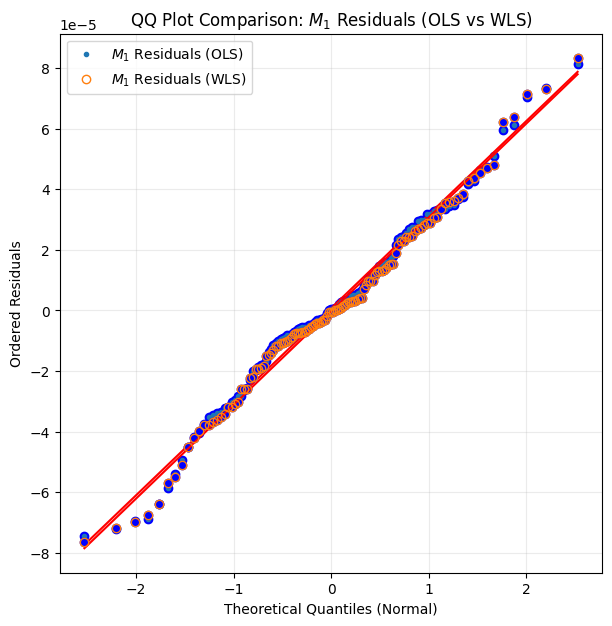

=== M1 Residual Summary ===
OLS: Mean=7.031e-07, Std=3.065e-05
WLS: Mean=-2.713e-07, Std=3.072e-05


In [19]:
# --- Example 2 (MOSFET I–V) — Code Cell for M1 OLS vs WLS Residual QQ Plot Comparison ---

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Unpack residuals from previous cells
resid_M1_OLS = data["resid_M1"]      # residuals from OLS fit of M1 (Code Cell 3)
resid_M1_WLS = data["resid_WLS_M1"]  # residuals from WLS fit of M1 (Code Cell 4R)

# Create a single QQ plot comparing OLS and WLS M1 residuals
plt.figure(figsize=(7, 7))

# Plot OLS residuals
(osm, osr), (slope, intercept, r) = stats.probplot(resid_M1_OLS, dist="norm", plot=plt)
plt.plot(osm, osr, '.', label="$M_1$ Residuals (OLS)") # Plot with label

# Plot WLS residuals (using a different marker or color for distinction)
(osm_wls, osr_wls), (slope_wls, intercept_wls, r_wls) = stats.probplot(resid_M1_WLS, dist="norm", plot=plt)
plt.plot(osm_wls, osr_wls, 'oC1', markerfacecolor='none', label="$M_1$ Residuals (WLS)") # Plot with label


plt.title("QQ Plot Comparison: $M_1$ Residuals (OLS vs WLS)")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Ordered Residuals")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()

# Optional: print basic stats for context
print("=== M1 Residual Summary ===")
print(f"OLS: Mean={np.mean(resid_M1_OLS):.3e}, Std={np.std(resid_M1_OLS, ddof=1):.3e}")
print(f"WLS: Mean={np.mean(resid_M1_WLS):.3e}, Std={np.std(resid_M1_WLS, ddof=1):.3e}")

# MODEL TESTING

## Stage 4 — Nested-model $F$-test (variance estimated) and AIC

With a **shared, data-estimated variance model** from Stage 3, we have weighted fits for both models:
- Simpler model $M_0:\ I_D^{(0)}(V_D)=a_1V_D+a_2V_D^2$
- Extended model $M_1:\ I_D^{(1)}(V_D)=\bigl(a_1V_D+a_2V_D^2\bigr)\,(1+\lambda V_D)$

We now ask: **Does adding $\lambda$ significantly improve the fit, beyond what random variation would explain?**

---

### 4.1 Weighted lack-of-fit measures

Using the **same** per-point variance estimate $\widehat{\sigma}_i^2$ for both models, define the weighted residual sums of squares (equivalently, weighted $\chi^2$):

$$
\chi^2(M_j)\;=\;\sum_{i=1}^N \frac{\bigl(I_{D,i}^{\mathrm{obs}}-\widehat{I}_{D,i}^{(j)}\bigr)^2}{\widehat{\sigma}_i^2},
\qquad j\in\{0,1\}.
$$

<br>

Let $p_0=2$ (parameters $a_1,a_2$) and $p_1=3$ (parameters $a_1,a_2,\lambda$). The degrees of freedom for $M_1$’s residual are $N-p_1$.

---

### 4.2 Partial $F$-test for nested models (variance estimated from data)

Because $M_0\subset M_1$ (set $\lambda=0$), the standard **partial $F$** statistic compares the improvement in lack-of-fit to the residual variance under the larger model:

$$
F\;=\;\frac{\bigl(\chi^2(M_0)-\chi^2(M_1)\bigr)/(p_1-p_0)}{\chi^2(M_1)/(N-p_1)}
\;=\;\frac{\Delta\chi^2/\Delta p}{\chi^2(M_1)/(N-p_1)},
\quad\text{with}\quad
\Delta p=p_1-p_0=1.
$$

<br>

- **Null hypothesis ($H_0$):** $\lambda=0$ (the simpler model suffices).  

- **Reference distribution:** under regular conditions and with variance estimated from data, $F$ is approximately $F_{\Delta p,\;N-p_1}$.

<br>

Compute the $p$-value as the **right-tail** probability:

$$
p\;=\;P\!\bigl(F_{\Delta p,\;N-p_1}\ge F_{\text{obs}}\bigr).
$$

<br>

**Decision rule (typical):** if $p<\alpha$ (e.g., $\alpha=0.05$), conclude that adding $\lambda$ provides a statistically meaningful improvement.

> **Note.** Using the **same** $\widehat{\sigma}_i^2$ for both models is essential for a fair comparison. Because the variance is **estimated** (not known), the partial $F$ approach is preferred here over a pure $\Delta\chi^2$ test.

---

### 4.3 Information criterion (AIC) for parsimony

To weigh improvement against complexity, compute the Akaike Information Criterion for each model:
$$
\mathrm{AIC}(M)\;=\;2k\;+\;\chi^2(M),
$$
where $k$ is the number of free parameters in the mean model ($k=p_0$ for $M_0$, $k=p_1$ for $M_1$). Report the difference
$$
\Delta\mathrm{AIC}\;=\;\mathrm{AIC}(M_1)-\mathrm{AIC}(M_0).
$$

**Heuristics:**
- $|\Delta\mathrm{AIC}|<2$: negligible evidence  
- $4$–$7$: moderate evidence  
- $>10$: strong evidence  
(negative $\Delta\mathrm{AIC}$ favors $M_1$)

AIC is especially helpful when $F$ is borderline or when assumptions are imperfect; it favors models that **earn** their extra parameter through substantial improvement.

---

### 4.4 What to report

- The statistic and its context:  
  $F$ with $(\Delta p,\;N-p_1)$ degrees of freedom, and its $p$-value.
- Lack-of-fit numbers: $\chi^2(M_0)$, $\chi^2(M_1)$, $\Delta\chi^2$.
- Parsimony: $\mathrm{AIC}(M_0)$, $\mathrm{AIC}(M_1)$, and $\Delta\mathrm{AIC}$.
- A one-sentence **verdict** combining the test result, AIC, and a brief comment on residual patterns at high $V_D$.

*Next:* We will add **Stage 5 — Parameter-level $t$-test for $\lambda$** and then the residual diagnostics cell.


In [20]:
# --- Example 2 (MOSFET I–V) — Code Cell 5: Partial F-test + AIC + compact verdict ---

import numpy as np
from scipy.stats import f as f_dist

# Unpack quantities prepared in Code Cell 4
Vd            = data["Vd"]
N             = Vd.size
chi2_M0       = data["chi2_M0"]       # weighted lack-of-fit under M0 (shared variance model)
chi2_M1       = data["chi2_M1"]       # weighted lack-of-fit under M1 (shared variance model)
k_WLS_M0      = data["k_hat_WLS_M0"]
k_WLS_M1      = data["k_hat_WLS_M1"]
lambda_WLS_M1 = data["lambda_hat_WLS_M1"]

# Parameter counts for the *mean* model in this piecewise formulation:
#   M0: k  -> p0 = 1
#   M1: k, λ  (implemented as θ1, θ2 but one is k and the other maps to λ) -> p1 = 2
p0, p1 = 1, 2
df1 = p1 - p0                 # numerator df = 1
df2 = N - p1                  # denominator df

# Partial F statistic (nested comparison with shared variance model)
delta_chi2 = chi2_M0 - chi2_M1
F_stat = (delta_chi2 / df1) / (chi2_M1 / df2)
p_val = 1.0 - f_dist.cdf(F_stat, df1, df2)

# AIC (using weighted chi^2 as lack-of-fit)
AIC_M0 = 2*p0 + chi2_M0
AIC_M1 = 2*p1 + chi2_M1
delta_AIC = AIC_M1 - AIC_M0   # negative favors M1

# Store F-test and AIC results in data for later cells
data.update({
    "F_stat": float(F_stat),
    "df1": int(df1),
    "df2": int(df2),
    "p_val": float(p_val),
    "AIC_M0": float(AIC_M0),
    "AIC_M1": float(AIC_M1),
    "delta_AIC": float(delta_AIC),
    "delta_chi2": float(delta_chi2) # Also store delta_chi2 for completeness
})


# Compact verdict helper
def verdict_text(p, dAIC, alpha=0.05):
    # Heuristics consistent with lecture notes
    if (p < alpha) and (dAIC < -4):
        return "M1 favored: F-test significant and ΔAIC is moderately/strongly negative."
    if (p < alpha) and (-4 <= dAIC < -2):
        return "M1 favored (borderline by AIC): significant F-test; mild parsimony penalty."
    if (p < alpha) and (dAIC >= -2):
        return "Mixed: significant F-test but ΔAIC small; practical importance may be limited."
    if (p >= alpha) and (dAIC <= -4):
        return "Mixed: AIC favors M1 but F-test not significant; check variance model and diagnostics."
    if (abs(dAIC) < 2) and (p >= alpha):
        return "Prefer M0: no significant improvement and ΔAIC negligible."
    if (dAIC > 2) and (p >= alpha):
        return "Prefer M0: F-test not significant and AIC penalizes added complexity."
    return "Ambiguous: examine residuals, CI for λ, and consider more data at higher V_D."

print("=== Partial F-test (shared-variance WLS) ===")
print(f"chi2(M0)     = {chi2_M0:.3f}")
print(f"chi2(M1)     = {chi2_M1:.3f}")
print(f"Δchi2        = {delta_chi2:.3f}")
print(f"F({df1},{df2}) = {F_stat:.3f}")
print(f"p-value      = {p_val:.4g}")

print("\n=== AIC (lower is better) ===")
print(f"AIC(M0)      = {AIC_M0:.3f}")
print(f"AIC(M1)      = {AIC_M1:.3f}")
print(f"ΔAIC (M1-M0) = {delta_AIC:.3f}   (negative favors M1)")

print("\n=== Parameter estimates (WLS) ===")
print(f"k̂ (M0)       = {k_WLS_M0:.6e} A/V^2")
print(f"k̂ (M1)       = {k_WLS_M1:.6e} A/V^2")
print(f"λ̂ (M1)       = {lambda_WLS_M1:.4f} 1/V")

print("\n--- Verdict ---")
print(verdict_text(p_val, delta_AIC))

=== Partial F-test (shared-variance WLS) ===
chi2(M0)     = 115.658
chi2(M1)     = 90.723
Δchi2        = 24.935
F(1,119) = 32.708
p-value      = 8.116e-08

=== AIC (lower is better) ===
AIC(M0)      = 117.658
AIC(M1)      = 94.723
ΔAIC (M1-M0) = -22.935   (negative favors M1)

=== Parameter estimates (WLS) ===
k̂ (M0)       = 2.056571e-03 A/V^2
k̂ (M1)       = 1.949646e-03 A/V^2
λ̂ (M1)       = 0.0812 1/V

--- Verdict ---
M1 favored: F-test significant and ΔAIC is moderately/strongly negative.


### Results: Nested-model F-test and AIC

Here are the results from the partial F-test and AIC analysis, comparing the baseline model ($M_0$) and the extended model ($M_1$) using weighted least squares with the shared variance model:

### Results:

Here are the results from the partial F-test and AIC analysis, comparing the baseline model ($M_0$) and the extended model ($M_1$) using weighted least squares with the shared variance model:

#### Partial F-test (shared-variance WLS)
$\chi^2(M_0) = 115.658$

$\chi^2(M_1) = 90.723$

$\Delta\chi^2 = 24.935$

$F(1,119) = 32.708$

$p$-value $= 8.116 \times 10^{-8}$

---

#### AIC (lower is better)

$\mathrm{AIC}(M_0) = 117.658$

$\mathrm{AIC}(M_1) = 94.723$

$\Delta\mathrm{AIC} (M_1-M_0) = -22.935$   
(negative favors $M_1$)

---

#### Parameter estimates (WLS)

$\hat{k} (M_0) = 2.056571 \times 10^{-3}$ A/V$^2$

$\hat{k} (M_1) = 1.949646 \times 10^{-3}$ A/V$^2$

$\hat{\lambda} (M_1) = 0.0812$ 1/V

Verdict:
M1 favored: F-test significant and $\Delta$AIC is moderately/strongly negative.

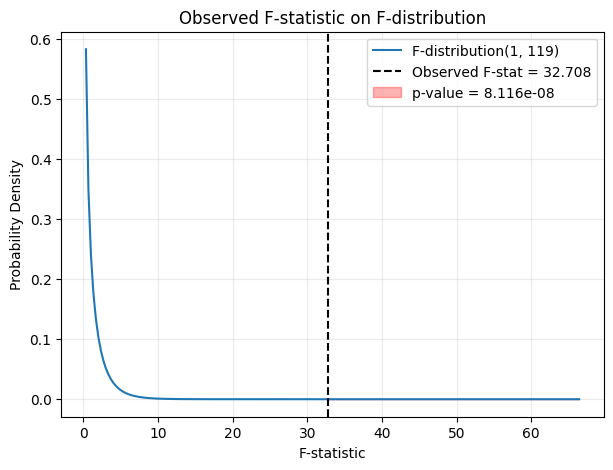

Observed F-statistic: 32.708
Degrees of freedom: df1=1, df2=119
Calculated p-value: 8.116e-08


In [21]:
# --- Example 2 (MOSFET I–V) — Code Cell to Visualize F-statistic on F-distribution ---

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f as f_dist

# Unpack F-statistic and degrees of freedom from previous cells
F_stat = data["F_stat"] # Or use the variable F_stat if it's still in scope
df1    = data["df1"]    # Or use the variable df1
df2    = data["df2"]    # Or use the variable df2

# Generate points for the F-distribution curve
x = np.linspace(0, F_stat * 2 + 1, 200) # Extend range beyond F_stat for visualization
pdf = f_dist.pdf(x, df1, df2)

# Plot the F-distribution PDF
plt.figure(figsize=(7, 5))
plt.plot(x, pdf, label=f'F-distribution({df1}, {df2})')

# Add a vertical line at the observed F-statistic
plt.axvline(F_stat, color='k', linestyle='--', label=f'Observed F-stat = {F_stat:.3f}')

# Shade the p-value region (right tail)
x_fill = np.linspace(F_stat, x[-1], 100)
y_fill = f_dist.pdf(x_fill, df1, df2)
plt.fill_between(x_fill, y_fill, color='red', alpha=0.3, label=f'p-value = {data["p_val"]:.4g}')

plt.xlabel('F-statistic')
plt.ylabel('Probability Density')
plt.title('Observed F-statistic on F-distribution')
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()

print(f"Observed F-statistic: {F_stat:.3f}")
print(f"Degrees of freedom: df1={df1}, df2={df2}")
print(f"Calculated p-value: {data['p_val']:.4g}")

# PARAMETER LEVEL MODEL EVALUATION

## Stage 5 — Parameter-level $t$-test for $\lambda$

The nested-model $F$-test in Stage&nbsp;4 answers the **model-level** question:
> Does adding the parameter $\lambda$ significantly improve the description of the data?

A complementary approach is to test the **parameter value itself**. After fitting $M_1$ by weighted least squares (using the variance model from Stage&nbsp;3), we obtain an estimate $\hat{\lambda}$ and its standard error $\mathrm{SE}(\hat{\lambda})$. To test whether the channel-length modulation effect is **nonzero**, we form the $t$ statistic

$$
t \;=\; \frac{\hat{\lambda}}{\mathrm{SE}(\hat{\lambda})},
$$

where the standard error comes from the **weighted** covariance matrix of the fitted parameters. Under the null hypothesis $H_0:\lambda=0$, and assuming approximate normality of the residuals, this statistic is approximately distributed as

$$
t_{N - p_1},
$$

with $N - p_1$ degrees of freedom ($p_1=3$ parameters for
$M_1$). The two-sided $p$-value is

$$
p \;=\; 2 \cdot P\!\bigl( t_{N - p_1} \ge |t_{\mathrm{obs}}| \bigr).
$$

### Interpreting the result
- A **large** $|t|$ and **small** $p$ suggest that $\lambda$ differs from zero in a statistically meaningful way.
- A **small** $|t|$ and **large** $p$ indicate that any apparent modulation could plausibly arise from measurement scatter.

### Relationship to the $F$-test
When adding **one** parameter to a linear-in-parameters model, the parameter-level $t$-test and the model-level $F$-test answer closely related questions:
- If $F$ is significant, $|t|$ is typically large.
- Borderline cases often show **consistency** (both agree the evidence is weak).
- Disagreement usually signals model mis-specification, variance mis-estimation, or insufficient diagnostic checks.

### Why we include this step
The $t$-test provides:
- An **effect size**: the magnitude of $\hat{\lambda}$.
- An **uncertainty**: $\mathrm{SE}(\hat{\lambda})$.
- A **confidence interval**: often more interpretable than a test statistic alone.

You will use all three—$F$, AIC, and $t$-tests—to form your final verdict. Each offers a different perspective on whether the observed up-curvature reflects **real physics** or **random variation**.


In [22]:
# --- Example 2 (MOSFET I–V) — Code Cell 6: Parameter-level t-test for lambda (WLS + delta method) ---

import numpy as np
from numpy.linalg import inv
from scipy.stats import t as t_dist

# Unpack from earlier cells
Vd          = data["Vd"]
Id_obs      = data["Id_obs"]
Vov         = data["Vov"]
w           = data["w"]                 # shared weights = 1 / sigma_hat^2
resid_WLS_M1 = data["resid_WLS_M1"]    # WLS residuals for M1
k_hat_WLS_M1  = data["k_hat_WLS_M1"]
lambda_hat_WLS_M1 = data["lambda_hat_WLS_M1"]

# Rebuild design matrix for M1:
# y ≈ θ1 * f(Vd) + θ2 * f(Vd) * Vd, where θ1 = k, θ2 = k*λ
def f_baseline(V):
    f_lin = (Vov*V - 0.5*V**2)
    f_sat = 0.5 * Vov**2 * np.ones_like(V)
    return np.where(V <= Vov, f_lin, f_sat)

fV  = f_baseline(Vd)
X1  = np.column_stack([fV, fV*Vd])
N   = Vd.size
p1  = 2  # parameters for M1: θ1 (=k), θ2 (=k*λ)

# WLS covariance for θ under shared weights:
#   Cov(θ) ≈ s2 * (X^T W X)^{-1},  with s2 estimated from WLS residuals
W = np.diag(w)
XTWX = X1.T @ (W @ X1)

# Residual variance estimate for WLS (since variance parameters were estimated from data)
# Here we use the usual s2 = (r^T W r) / (N - p1)   (equivalent to chi2_M1 / (N - p1))
RSS_w = float(resid_WLS_M1.T @ (w * resid_WLS_M1))   # r^T W r
df    = N - p1
s2    = RSS_w / df

Cov_theta = s2 * inv(XTWX)

# Delta-method standard error for lambda = θ2 / θ1
theta1 = k_hat_WLS_M1
theta2 = k_hat_WLS_M1 * lambda_hat_WLS_M1   # by definition
lambda_hat = lambda_hat_WLS_M1

# Gradient of g(θ1, θ2) = θ2 / θ1:
# ∂g/∂θ1 = -θ2 / θ1^2 = -λ / θ1
# ∂g/∂θ2 =  1 / θ1
grad = np.array([ -lambda_hat / theta1, 1.0 / theta1 ])

var_lambda = float(grad.T @ (Cov_theta @ grad))
se_lambda  = np.sqrt(max(var_lambda, 0.0))

# t-test for H0: λ = 0 (two-sided)
t_stat = lambda_hat / se_lambda if se_lambda > 0 else np.inf
p_val  = 2.0 * (1.0 - t_dist.cdf(abs(t_stat), df=df))

# 95% CI for lambda
alpha = 0.05
tcrit = t_dist.ppf(1.0 - alpha/2.0, df=df)
ci_lo = lambda_hat - tcrit * se_lambda
ci_hi = lambda_hat + tcrit * se_lambda

print("=== Parameter-level t-test for λ (WLS + delta method) ===")
print(f"λ̂ (M1, WLS)        = {lambda_hat:.5f} 1/V")
print(f"SE(λ̂)              = {se_lambda:.5f} 1/V")
print(f"t({df})             = {t_stat:.3f}")
print(f"p-value (two-sided) = {p_val:.4g}")
print(f"95% CI for λ        = [{ci_lo:.5f}, {ci_hi:.5f}]  1/V")

# Quick consistency note (optional)
if p_val < 0.05:
    print("\nNote: The parameter-level t-test suggests λ ≠ 0 at the 5% level.")
else:
    print("\nNote: The parameter-level t-test does NOT reject λ = 0 at the 5% level.")


=== Parameter-level t-test for λ (WLS + delta method) ===
λ̂ (M1, WLS)        = 0.08121 1/V
SE(λ̂)              = 0.01498 1/V
t(119)             = 5.420
p-value (two-sided) = 3.162e-07
95% CI for λ        = [0.05154, 0.11087]  1/V

Note: The parameter-level t-test suggests λ ≠ 0 at the 5% level.


### Results: Parameter-level $t$-test for $\lambda$

Here are the results from the parameter-level $t$-test for $\lambda$, performed on the weighted least squares fit of $M_1$:

$\hat{\lambda} (M_1, \mathrm{WLS}) = 0.08121$ 1/V

$\mathrm{SE}(\hat{\lambda}) = 0.01498$ 1/V

$t(119) = 5.420$

$p$-value (two-sided) $= 3.162 \times 10^{-7}$

$95\%$ CI for $\lambda = [0.05154, 0.11087]$ 1/V

*Note:* The parameter-level $t$-test suggests $\lambda \neq 0$ at the 5% level.

## Reminder — Confidence intervals for $\hat{\lambda}$

Reporting hypothesis tests alone (such as a $t$-test or partial $F$-test) does not communicate **how large** the estimated effect is, nor how precisely we know it. A **confidence interval (CI)** answers both questions by providing a plausible numerical range for $\lambda$ based on the data and the estimated variance.

For a weighted least-squares fit of $M_1$, we retrieve:
- the parameter estimate $\hat{\lambda}$
- its standard error $\mathrm{SE}(\hat{\lambda})$
- the residual degrees of freedom $N - p_1$ (with $p_1 = 3$ parameters)

A **$(1-\alpha)$ two-sided confidence interval** has the form
$$
\hat{\lambda} \;\pm\; t_{\alpha/2,\;N - p_1}\;\mathrm{SE}(\hat{\lambda}),
$$
where $t_{\alpha/2,\;d}$ is the upper $\alpha/2$ quantile of the Student $t$ distribution with $d$ degrees of freedom.

**Example choices:**
- For approximately $95\%$ confidence, use $\alpha = 0.05$.
- For approximately $90\%$ confidence, use $\alpha = 0.10$ (wider tail probabilities).

### Interpretation
- If the interval **includes zero**, the data are consistent with $\lambda = 0$; the apparent effect may be noise.
- If the interval lies entirely on one side of zero, the sign of $\lambda$ is **statistically supported** by the data.
- The **width** of the interval reflects uncertainty: wide intervals warn that the estimate is not well constrained.

### Why this matters physically
A statistically significant $p$-value with a **tiny** $\hat{\lambda}$ may be physically irrelevant. Conversely, a slightly non-significant $p$ with a moderately sized interval may prompt you to collect more data. Confidence intervals encourage you to reason about:
- magnitude,
- direction,
- uncertainty,
not just yes/no significance.

In summary:
- Always report $\hat{\lambda}$, $\mathrm{SE}(\hat{\lambda})$, and a confidence interval.
- Use the interval to interpret the **practical** importance of channel-length modulation.


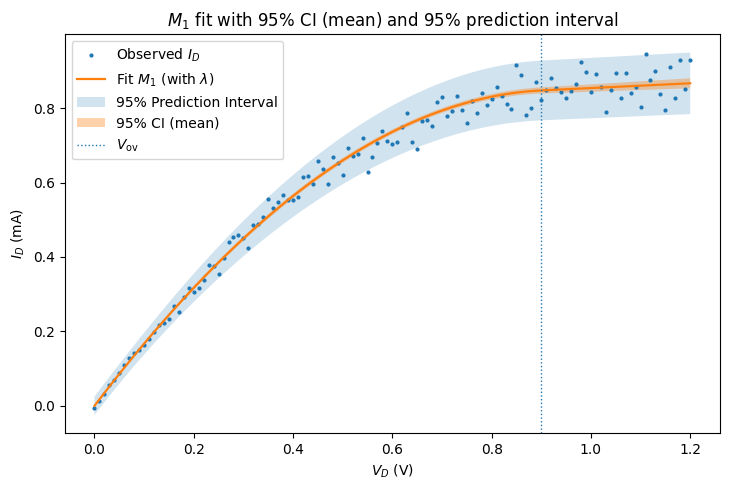

Fraction of points inside 95% CI (mean): 18.2%  (expect << 95%)
Fraction of points inside 95% Prediction Interval: 97.5%  (expect ~95%)
df = 119, t_crit(95%) ≈ 1.980


In [23]:
# --- Example 2 (MOSFET I–V) — Code Cell 7P: Mean CI *and* 95% Prediction Intervals for M1 ---

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.stats import t as t_dist

# Unpack from previous cells
Vd                 = data["Vd"]
Id_obs             = data["Id_obs"]
Vov                = data["Vov"]
w                  = data["w"]                 # shared weights = 1 / sigma_hat^2
sigma_hat_sq       = data["sigma_hat_sq"]     # per-point variance from shared variance model (Stage 3/4R)
k_hat_WLS_M1       = data["k_hat_WLS_M1"]
lambda_hat_WLS_M1  = data["lambda_hat_WLS_M1"]
resid_WLS_M1       = data["resid_WLS_M1"]

# Basis and design for M1 (linear in parameters θ = [θ1, θ2] = [k, k*λ])
def f_baseline(V):
    f_lin = (Vov*V - 0.5*V**2)
    f_sat = 0.5 * Vov**2 * np.ones_like(V)
    return np.where(V <= Vov, f_lin, f_sat)

fV  = f_baseline(Vd)
X1  = np.column_stack([fV, fV*Vd])

# Rebuild WLS covariance of θ
N   = Vd.size
p1  = 2
W   = np.diag(w)
XTWX = X1.T @ (W @ X1)

RSS_w = float(resid_WLS_M1.T @ (w * resid_WLS_M1))   # r^T W r
df    = N - p1
s2    = RSS_w / df
Cov_theta = s2 * inv(XTWX)

# Mean prediction and its standard error (confidence band)
theta1 = k_hat_WLS_M1
theta2 = k_hat_WLS_M1 * lambda_hat_WLS_M1
theta_hat = np.array([theta1, theta2])

yhat     = X1 @ theta_hat
var_mean = np.einsum('ij,jk,ik->i', X1, Cov_theta, X1)   # diag(X Covθ X^T)
se_mean  = np.sqrt(np.maximum(var_mean, 0.0))

alpha = 0.05
tcrit = t_dist.ppf(1.0 - alpha/2.0, df=df)

# 95% Confidence Interval for the MEAN
ci_lo = yhat - tcrit * se_mean
ci_hi = yhat + tcrit * se_mean

# 95% Prediction Interval for INDIVIDUAL observations: add measurement noise variance
# Var(prediction error) = Var(mean) + sigma_hat_sq
se_pred = np.sqrt(np.maximum(var_mean + sigma_hat_sq, 0.0))
pi_lo   = yhat - tcrit * se_pred
pi_hi   = yhat + tcrit * se_pred

# Plot
plt.figure(figsize=(7.4, 5.0))
plt.plot(Vd, Id_obs*1e3, ".", ms=4, label="Observed $I_D$")
plt.plot(Vd, yhat*1e3, "-", lw=1.6, label=r"Fit $M_1$ (with $\lambda$)")

# Shaded bands: prediction interval (wide) under/behind, mean CI (narrow) on top
plt.fill_between(Vd, pi_lo*1e3, pi_hi*1e3, alpha=0.20, label="95% Prediction Interval")
plt.fill_between(Vd, ci_lo*1e3, ci_hi*1e3, alpha=0.35, label="95% CI (mean)")

plt.axvline(Vov, ls=":", lw=1.0, label=r"$V_{\mathrm{ov}}$")
plt.xlabel("$V_D$ (V)")
plt.ylabel("$I_D$ (mA)")
plt.title(r"$M_1$ fit with 95% CI (mean) and 95% prediction interval")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Coverage diagnostics
inside_CI = np.mean((Id_obs >= ci_lo) & (Id_obs <= ci_hi))
inside_PI = np.mean((Id_obs >= pi_lo) & (Id_obs <= pi_hi))
print(f"Fraction of points inside 95% CI (mean): {inside_CI*100:.1f}%  (expect << 95%)")
print(f"Fraction of points inside 95% Prediction Interval: {inside_PI*100:.1f}%  (expect ~95%)")
print(f"df = {df}, t_crit(95%) ≈ {tcrit:.3f}")


# RESIDUAL DIAGNOSTICS

## Stage 6 — Residual diagnostics and QQ plots

After choosing between $M_0$ and $M_1$ using formal tests, we must still ask:
> Do the residuals look compatible with our modeling assumptions?

Residual diagnostics help us detect **systematic structure** that would invalidate conclusions from the $F$-test, AIC, or $t$-tests. In this stage, you will examine several complementary visual tools.

### 6.1 Residuals vs $V_D$
Plot the **standardized residual** for each point against $V_D$:
- Ideally, points scatter randomly around zero with no clear pattern.
- A **consistent upward trend** at large $V_D$ under $M_0$ often indicates underfitting (missing channel-length modulation).
- If $M_1$ still leaves a pattern (e.g., curvature), then even the extended model may be mis-specified.

### 6.2 Residuals vs fitted values
Plot standardized residuals vs $\widehat{I}_D$:
- Look for a **fan shape**, which suggests heteroskedasticity (variance grows with current).
- If the fan shape weakens after weighted least squares (Stage 3), the variance model is doing its job.
- If fan-shaping persists, consider modifying the variance model or adding terms to the mean model.

### 6.3 Histogram of standardized residuals
You should see an approximately symmetric bell-shaped distribution centered on zero.
- **Heavy tails** may indicate outliers or an inadequate variance model.
- **Asymmetric** histograms suggest bias.

### 6.4 QQ plot (quantile–quantile plot)
A QQ plot compares the ordered standardized residuals to the quantiles of a normal distribution:
- If points lie close to a straight line, normality is reasonable.
- **Upward bow in the tails**: heavier-tailed residuals than normal.
- **S-shaped curve**: too many central points and too many outliers; the model may be poorly specified.

A useful cartoon analogy: imagine lining students up in order of height and comparing them to “expected height” cardboard cutouts. Deviations from the straight line tell you **where** the distribution differs—from the center or from the tails.

### 6.5 What to conclude from diagnostics
Residual diagnostics often reveal information that formal tests do not:
- A highly significant $F$-test means little if residuals are structured.
- A non-significant $F$-test with **strong** residual structure may suggest missing physics, omitted variables, or domain mismatch.
- Well-behaved residuals under $M_1$ provide **visual confirmation** that the channel-length modulation term is capturing the key trend.

### 6.6 How diagnostics inform future modeling
If residuals remain structured:
- Revisit your variance model: try a different functional form for $\widehat{\sigma}_i^2$.
- Consider additional physical effects: contact resistance, series parasitics, or thermal contributions.
- Expand the fitting window or collect more data in suspicious regions.

Diagnostics bridge the gap between **statistical evidence** and **physical intuition**. When both align, you have a persuasive modeling result.


/tmp/ipython-input-2935055990.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


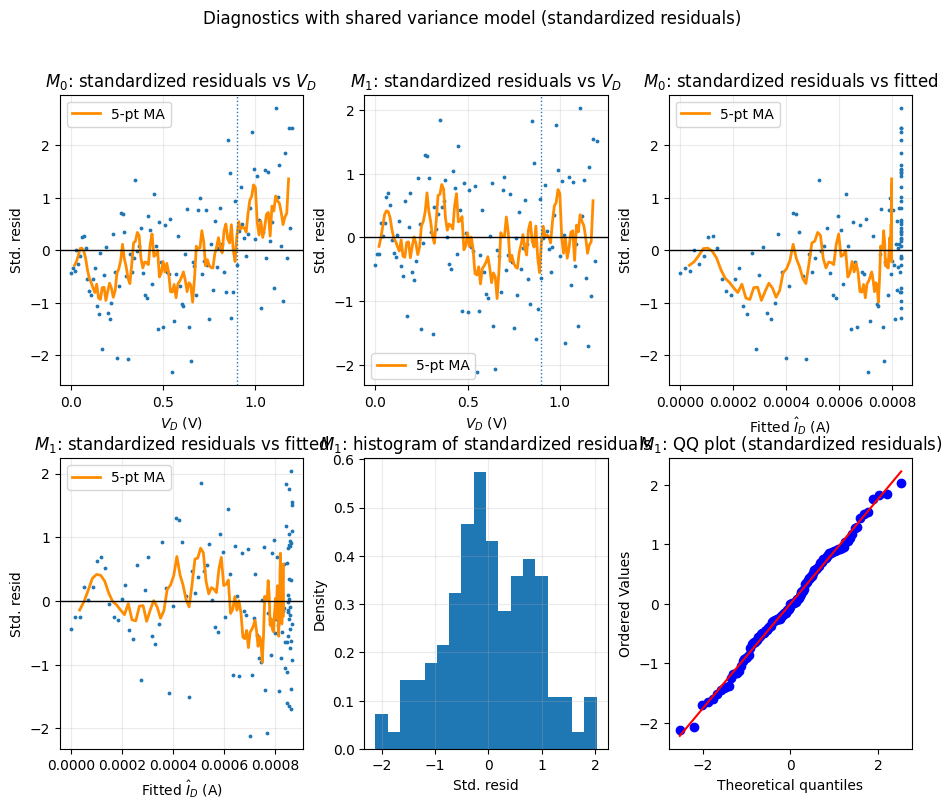

Std resid M0: mean=-0.031, std=0.981, N=121
Std resid M1: mean=0.002, std=0.869, N=121


In [24]:
# --- Example 2 (MOSFET I–V) — Code Cell 8: Diagnostics with standardized residuals (shared variance model) ---

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Unpack results from previous cells
Vd             = data["Vd"]
Id_obs         = data["Id_obs"]
Vov            = data["Vov"]
sigma_hat_sq   = data["sigma_hat_sq"]    # per-point variance from shared variance model
Id_hat_WLS_M0  = data["Id_hat_WLS_M0"]
Id_hat_WLS_M1  = data["Id_hat_WLS_M1"]
resid_WLS_M0   = data["resid_WLS_M0"]
resid_WLS_M1   = data["resid_WLS_M1"]

# Standardized residuals
std_res_M0 = resid_WLS_M0 / np.sqrt(sigma_hat_sq)
std_res_M1 = resid_WLS_M1 / np.sqrt(sigma_hat_sq)

# Function to calculate moving average
def moving_average(data, window_size):
    """Calculates a simple moving average."""
    if window_size <= 1:
        return data
    if window_size > len(data):
        return np.full_like(data, np.mean(data))
    weights = np.ones(window_size) / window_size
    # Use 'valid' mode to avoid padding, resulting in a shorter array
    return np.convolve(data, weights, mode='valid')

# Calculate moving averages (5 points)
window_size = 5

# Moving average for M0 vs Vd
# Need to sort by Vd to apply moving average correctly
sort_idx_Vd = np.argsort(Vd)
Vd_sorted = Vd[sort_idx_Vd]
std_res_M0_sorted_by_Vd = std_res_M0[sort_idx_Vd]
ma_std_res_M0_Vd = moving_average(std_res_M0_sorted_by_Vd, window_size)
# Align moving average with the center of the window for plotting
ma_Vd_centers = Vd_sorted[window_size - 1:] - (Vd_sorted[window_size - 1] - Vd_sorted[0]) / 2.0


# Moving average for M1 vs Vd
std_res_M1_sorted_by_Vd = std_res_M1[sort_idx_Vd]
ma_std_res_M1_Vd = moving_average(std_res_M1_sorted_by_Vd, window_size)
# Align moving average with the center of the window for plotting
# Using the same Vd_sorted and ma_Vd_centers as for M0 vs Vd

# Moving average for M0 vs Fitted
# Need to sort by fitted values
sort_idx_M0_fitted = np.argsort(Id_hat_WLS_M0)
Id_hat_WLS_M0_sorted = Id_hat_WLS_M0[sort_idx_M0_fitted]
std_res_M0_sorted_by_fitted = std_res_M0[sort_idx_M0_fitted]
ma_std_res_M0_fitted = moving_average(std_res_M0_sorted_by_fitted, window_size)
# Align moving average with the center of the window for plotting
ma_fitted_M0_centers = Id_hat_WLS_M0_sorted[window_size - 1:] - (Id_hat_WLS_M0_sorted[window_size - 1] - Id_hat_WLS_M0_sorted[0]) / 2.0


# Moving average for M1 vs Fitted
sort_idx_M1_fitted = np.argsort(Id_hat_WLS_M1)
Id_hat_WLS_M1_sorted = Id_hat_WLS_M1[sort_idx_M1_fitted]
std_res_M1_sorted_by_fitted = std_res_M1[sort_idx_M1_fitted]
ma_std_res_M1_fitted = moving_average(std_res_M1_sorted_by_fitted, window_size)
# Align moving average with the center of the window for plotting
ma_fitted_M1_centers = Id_hat_WLS_M1_sorted[window_size - 1:] - (Id_hat_WLS_M1_sorted[window_size - 1] - Id_hat_WLS_M1_sorted[0]) / 2.0


# One figure with multiple diagnostics
fig = plt.figure(figsize=(11.0, 8.5))
gs = fig.add_gridspec(nrows=2, ncols=3, height_ratios=[1.0, 1.0], wspace=0.25, hspace=0.25)

# (a) Standardized residuals vs Vd (M0)
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(Vd, std_res_M0, ".", ms=3.5)
ax1.plot(ma_Vd_centers, ma_std_res_M0_Vd, color='darkorange', lw=2, label=f'{window_size}-pt MA') # Add moving average
ax1.axhline(0.0, lw=1.0, color="k")
ax1.axvline(Vov, ls=":", lw=1.0)
ax1.set_xlabel("$V_D$ (V)")
ax1.set_ylabel("Std. resid")
ax1.set_title(r"$M_0$: standardized residuals vs $V_D$")
ax1.grid(True, alpha=0.25)
ax1.legend()

# (b) Standardized residuals vs Vd (M1)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(Vd, std_res_M1, ".", ms=3.5)
ax2.plot(ma_Vd_centers, ma_std_res_M1_Vd, color='darkorange', lw=2, label=f'{window_size}-pt MA') # Add moving average
ax2.axhline(0.0, lw=1.0, color="k")
ax2.axvline(Vov, ls=":", lw=1.0)
ax2.set_xlabel("$V_D$ (V)")
ax2.set_ylabel("Std. resid")
ax2.set_title(r"$M_1$: standardized residuals vs $V_D$")
ax2.grid(True, alpha=0.25)
ax2.legend()


# (c) Std residuals vs fitted (M0)
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(Id_hat_WLS_M0, std_res_M0, ".", ms=3.5)
ax3.plot(ma_fitted_M0_centers, ma_std_res_M0_fitted, color='darkorange', lw=2, label=f'{window_size}-pt MA') # Add moving average
ax3.axhline(0.0, lw=1.0, color="k")
ax3.set_xlabel("Fitted $\\hat{I}_D$ (A)")
ax3.set_ylabel("Std. resid")
ax3.set_title(r"$M_0$: standardized residuals vs fitted")
ax3.grid(True, alpha=0.25)
ax3.legend()


# (d) Std residuals vs fitted (M1)
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(Id_hat_WLS_M1, std_res_M1, ".", ms=3.5)
ax4.plot(ma_fitted_M1_centers, ma_std_res_M1_fitted, color='darkorange', lw=2, label=f'{window_size}-pt MA') # Add moving average
ax4.axhline(0.0, lw=1.0, color="k")
ax4.set_xlabel("Fitted $\\hat{I}_D$ (A)")
ax4.set_ylabel("Std. resid")
ax4.set_title(r"$M_1$: standardized residuals vs fitted")
ax4.grid(True, alpha=0.25)
ax4.legend()


# (e) Histogram of standardized residuals (M1)
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(std_res_M1, bins=18, density=True)
ax5.set_xlabel("Std. resid")
ax5.set_ylabel("Density")
ax5.set_title(r"$M_1$: histogram of standardized residuals")
ax5.grid(True, alpha=0.25)

# (f) QQ plot (M1 standardized residuals)
ax6 = fig.add_subplot(gs[1, 2])
stats.probplot(std_res_M1, dist="norm", plot=ax6)
ax6.set_title(r"$M_1$: QQ plot (standardized residuals)")

plt.suptitle("Diagnostics with shared variance model (standardized residuals)", y=0.98)
plt.tight_layout()
plt.show()

# Simple numeric summaries
def summarize(name, r):
    return f"{name}: mean={np.mean(r):.3f}, std={np.std(r, ddof=1):.3f}, N={r.size}"

print(summarize("Std resid M0", std_res_M0))
print(summarize("Std resid M1", std_res_M1))

## Common pitfalls when evaluating whether a new model term is justified

Even when formal tests are available, it is easy to misinterpret evidence when evaluating a small systematic effect such as channel-length modulation. Below are common pitfalls to avoid:

### 1. Trusting visual overlays too much
Two fitted curves can look nearly identical when plotted together. Visual similarity alone does **not** imply that the simpler model is correct. Always inspect **residuals**, which amplify subtle differences.

### 2. Overreacting to a few noisy points
A small number of extreme residuals can occur by chance. Decisions should be based on **patterns**, not isolated outliers.

### 3. Ignoring how variance grows with signal level
Current often becomes more variable at higher $V_D$. Failing to estimate $\widehat{\sigma}_i^2$ can give **too much weight** to high-current points and artificially favor the extended model.

### 4. Assuming $p$-values are decisive on their own
In borderline cases, $p$-values are sensitive to small changes in variance estimates. Combine evidence from:
- the $F$-test,
- $\Delta\mathrm{AIC}$,
- the $t$-test on $\hat{\lambda}$,
- residual diagnostics.

### 5. Ignoring effect size
A statistically significant $\hat{\lambda}$ that is **nearly zero** may be physically unimportant. Always interpret effect size and confidence intervals.

### 6. Forgetting that nested models require a **shared** variance model
When each model is allowed its own variance estimate, the comparison becomes unfair. Always compare $\chi^2(M_0)$ and $\chi^2(M_1)$ using the **same** $\widehat{\sigma}_i^2$.

### 7. Mistaking systematic residual structure for random variation
Residual patterns can reveal missing physics long before statistics do. A lingering upward trend at high $V_D$ under $M_1$ may suggest contact resistance or thermal effects, not $\lambda$.

### 8. Accepting a model because diagnostics look “good enough”
A flat residual plot alone does not guarantee correctness. Diagnostics detect **violations**, not **truth**.

### 9. Focusing only on significance, not complexity
AIC penalizes unnecessary parameters. If $\Delta\mathrm{AIC}$ is small (e.g., < 2), the simpler model may be preferable—even with a nearly significant $p$-value.

### 10. Neglecting the measurement window
$\lambda$ may only matter over a limited $V_D$ range. If most points are in the low-bias region, the effect will be harder to detect reliably.

---

**Bottom line:**  
Treat model comparison like a scientific investigation:
- Look at multiple lines of evidence,
- Check assumptions visually,
- Interpret effect size,
- Ask whether the result makes **physical** sense.


# DISCUSSION: VARIANCE ESTIMATION

## Stage 7 — Why variance estimation matters

In many real electrical measurements, we do **not** know the true variance of each data point ahead of time. Instead, we must **estimate** the noise level from the data itself. This distinction fundamentally affects how confidently we can detect small systematic effects, such as channel-length modulation.

When variance is **known** (as in Example 1):
- Weighted least squares uses the correct weights immediately.
- Residual scatter scales properly with intensity.
- Statistical tests have higher power (they more easily detect small effects).
- Assumptions about residual variance are built into the model inputs.

When variance is **estimated** (this example):
- We must use initial residuals to infer how noise depends on the signal.
- Parameter standard errors grow, especially in borderline cases.
- Nested model tests (like the partial $F$-test) become more conservative.
- Confidence intervals widen, reflecting increased uncertainty.

A common reason to estimate variance is **heteroskedasticity**: measurement scatter grows with current magnitude. If this is ignored, high-current points unfairly dominate the fit, leading to:
- biased parameter estimates,
- overly optimistic significance tests,
- misleading residual diagnostics.

By modeling variance as
$$
\widehat{\sigma}_i^2 \approx \widehat{\sigma}_0^2 + \widehat{\gamma}^2\,\widehat{I}_i^2,
$$
we account for both a **floor** (instrument noise) and a **signal-proportional** component (shot-like or amplifier noise). Weighted refits downweight noisy regions, making comparisons between $M_0$ and $M_1$ **fair**.

### Practical consequences
- Borderline effects (small $\lambda$) may **not** reach significance once uncertainty is inflated.
- Overconfident p-values shrink toward zero when variance is treated properly.
- $\Delta\chi^2$ becomes less dramatic because error bars are realistic.
- Conclusions become more robust to experimental imperfections.

### Physical interpretation
Variance estimation prevents us from mistaking **random scatter** at high $V_D$ for **real physics**. Only when the extended model reduces **weighted** residual structure in a consistent way should we conclude that channel-length modulation is present.

In short:
> When variance is estimated from data, statistical tests are harder to “fool,” and verdicts are more trustworthy.


## Stage 8 — Physics interpretation & verdict templates

After performing statistical tests, computing information criteria, and examining residual structure, you should synthesize **all** evidence to form a clear, physically motivated conclusion. The goal is not just to “win the test,” but to understand whether channel-length modulation is **actually** influencing device behavior in your measurement window.

### 8.1 Connect statistical evidence to device physics
If the parameter $\lambda$ is significantly different from zero and residual patterns improve under $M_1$, this supports the interpretation that the effective channel length decreases with increasing $V_D$, slightly increasing the drain current in saturation. This behavior is consistent with common MOSFET models.

If $\lambda$ is not statistically significant, then either:
- channel-length modulation is not detectable at this bias range, or
- measurement uncertainty obscures the effect, or
- the data may not include a large enough high-$V_D$ region.

### 8.2 Consider effect size and confidence intervals
Even if $p < 0.05$, a **very** small $\hat{\lambda}$ and a narrow confidence interval containing values close to zero may indicate a **negligible** practical effect. Conversely, if the interval sits wholly above zero with compatible magnitude, the effect is both statistically and physically meaningful.

### 8.3 Inspect residuals one more time
Before finalizing a verdict, revisit residual diagnostics:
- Are standardized residuals roughly structure-free?
- Has the high-$V_D$ tilt disappeared under $M_1$?
- Does the QQ plot remain reasonably linear (especially in the tails)?
If not, even a statistically significant $\lambda$ may reflect **mis-specified** physics.

### 8.4 Cross-check model complexity with AIC
AIC penalizes unnecessary parameters:
- If $\Delta\mathrm{AIC} < -4$, the improvement tends to outweigh added complexity.
- If $|\Delta\mathrm{AIC}| < 2$, the case is weak—prefer the simpler model.

### 8.5 Verdict templates you can adapt

**Verdict (channel-length modulation supported):**
> The extended model $M_1$ significantly reduces weighted residual structure at high $V_D$, with $\hat{\lambda}$ significantly different from zero ($p = \dots$), a negative $\Delta\mathrm{AIC}$, and flatter standardized residuals. Confidence intervals exclude zero, indicating a physically meaningful effect. We therefore conclude that channel-length modulation influences the measured $I$–$V$ behavior in this bias range.

**Verdict (no detectable modulation):**
> Although $M_1$ fits slightly better, the improvement is not statistically significant ($p = \dots$), $\Delta\mathrm{AIC}$ is small, and confidence intervals for $\hat{\lambda}$ include zero. Residual diagnostics show no distinctive trend at high $V_D$. We therefore favor the simpler model $M_0$.

**Verdict (ambiguous/borderline case):**
> The improvement from $M_1$ is marginal ($p \approx \dots$), and $\Delta\mathrm{AIC}$ is small. Residual patterns weaken but do not disappear. The confidence interval for $\hat{\lambda}$ touches zero. Additional data at larger $V_D$ or lower noise would be needed to reach a definitive conclusion.

### 8.6 Emphasize scientific judgment
Model comparison is not just statistics—scientific reasoning matters:
- Does the sign of $\hat{\lambda}$ match expectations?
- Is the measurement window appropriate?
- Do diagnostics suggest missing physics?

In summary:
> Combine formal tests, uncertainty estimates, residual diagnostics, and physical interpretation to produce a concise, defensible, scientifically grounded verdict.


## Failure modes and how to recognize them

Even when the extended model $M_1$ appears to improve the fit, several failure modes can mislead your interpretation. Recognizing these patterns will help you avoid drawing incorrect physical conclusions.

### 1. Apparent improvement caused by noise at high $V_D$
If the variance of the measurements increases strongly with current, the high-$V_D$ region may contain large random fluctuations that mimic upward curvature. In this situation, adding $\lambda$ can appear beneficial even when the true underlying physics does not include channel-length modulation. Weighted least squares helps, but you should also verify that the **standardized** residuals at high $V_D$ become structure-free.

### 2. Variance model mis-specification
If your estimated variance model $\widehat{\sigma}_i^2$ does not match the way noise actually grows with signal level, the weights you assign to each point can be incorrect. Inaccurate weights either exaggerate the evidence for $\lambda$ or wash it out entirely. Residual fan-shapes and curved QQ plots often indicate a poor variance model.

### 3. Physically missing terms disguised as channel-length modulation
Other device effects—such as contact resistance, series parasitics, or joule-heating behavior—can produce trends that superficially resemble channel-length modulation. In these cases, $\hat{\lambda}$ may absorb the influence of the missing physics. If residuals remain structured under $M_1$, consider alternative physical mechanisms.

### 4. Overfitting when $\lambda$ competes with limited data
If most data points fall in a low-$V_D$ region where channel-length modulation is weak, the fit may rely heavily on a small number of high-$V_D$ points. In such cases, $\hat{\lambda}$ becomes poorly constrained and overly sensitive to noise, resulting in large standard errors and unstable $p$-values. Confidence intervals that span zero warn you that the effect is not reliably detected.

### 5. Non-identifiability between parameters
If $a_2$ (the quadratic term) and $\lambda$ both shape the curvature in similar ways over the measurement window, the two parameters may become correlated. High correlation inflates their standard errors, making statistical conclusions uncertain. This problem frequently arises when the voltage range is too narrow to separate the effects.

### 6. Borderline significance without practical importance
A parameter can be statistically significant while being **physically insignificant**. If the confidence interval is narrow but clustered near zero, the effect may not meaningfully change device behavior. Always interpret effect size alongside statistical results.

### 7. Local fitting choices that bias the conclusion
Restricting the voltage window to a region where curvature is strongest can exaggerate the statistical support for $\lambda$. Conversely, using too wide a window may dilute the signal. The measurement window should match the regime where the physical effect is expected.

### 8. Residual structure that persists even when $\lambda$ is included
If residual plots still display systematic trends at high $V_D$, then channel-length modulation does not fully explain the observed behavior. In this case, $M_1$ is an improvement, but still incomplete. Additional model terms or improved physics may be required.

### 9. Heavy-tailed residuals mistaken for missing physics
If the QQ plot shows heavier-than-normal tails, rare large deviations may look like systematic curvature. Heavy-tailed residuals point to occasional measurement spikes, not necessarily a real device effect. Modifying the variance model or discarding obvious outliers can help.

### 10. Drawing conclusions from visual overlays alone
Two fits can appear nearly identical when plotted over the data. Relying solely on visual inspection can hide subtle improvements or lingering bias. Formal comparisons, standardized residual plots, and confidence intervals are essential for making reliable decisions.

---

**In summary:**  
Failure modes typically involve either a mis-modeled noise structure, parameter degeneracy, or missing physics. If you observe unstable parameter estimates, lingering residual patterns, or ambiguous confidence intervals, treat your conclusion cautiously and consider collecting additional data.
